In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.models import resnet50
import torchvision.transforms.v2 as v2
import torchvision.transforms as t
from torch.utils.data import Dataset, DataLoader, random_split
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Implementing the model proposed by JEONG

In [3]:
fake_image = Image.open("/kaggle/input/real-and-fake-images/dataset/train/fake_images/F_SyCA_00000.png")
fake_gray = fake_image.convert('L')
fake_array = np.array(fake_gray)

fake_array.shape

(299, 299)

In [4]:
LR = 5e-4
BATCH_SIZE = 32
EPOCHS = 500

In [5]:
transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor(),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
dataset = torchvision.datasets.ImageFolder('/kaggle/input/real-and-fake-images/dataset/train', transform=transform)

indices = [i for i, label in enumerate(dataset.targets) if label == 1]

subset = torch.utils.data.Subset(dataset, indices)

dataloader = torch.utils.data.DataLoader(subset, shuffle=True, batch_size=BATCH_SIZE)

## Autoencoder with high amount of sub/upsampling

In [6]:
class AutoencoderHigh(nn.Module):
    def __init__(self):
        super(AutoencoderHigh, self).__init__()

        # ENCODER
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # [B, 48, 32, 32]

            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # [B, 96, 16, 16]

            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),  # [B, 192, 8, 8]

            nn.Conv2d(192, 32, kernel_size=1),  # [B, 32, 8, 8]
            nn.ReLU(inplace=True)
        )

        # DECODER
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 192, kernel_size=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 192, 16, 16]
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 192, 32, 32]
            nn.Conv2d(192, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 96, 64, 64]
            nn.Conv2d(96, 48, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(48, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

## Autoencoder with low amount of sub/upsampling

In [7]:
class AutoencoderLow(nn.Module):
    def __init__(self):
        super(AutoencoderLow, self).__init__()

        # ENCODER com apenas uma camada convolucional
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 64, 64]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)  # [B, 32, 32, 32]
        )

        # DECODER com apenas uma camada convolucional
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # [B, 32, 64, 64]
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # [B, 3, 64, 64]
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

## Autoencoder without sub/upsampling

In [8]:
class AutoencoderNon(nn.Module):
    def __init__(self):
        super(AutoencoderNon, self).__init__()
        
        # ENCODER
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 128, 128]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 128, 128]
            nn.ReLU(),
        )

        # DECODER
        self.decoder = nn.Sequential(
            # Simulando transposed conv com upsample + conv
            nn.Upsample(scale_factor=1, mode='bilinear', align_corners=False),  # mesma dimensão
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 128, 128]
            nn.ReLU(),

            nn.Upsample(scale_factor=1, mode='bilinear', align_corners=False),  # mesma dimensão
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),  # [B, 3, 128, 128]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Feature extractor with perceptual loss

In [9]:
from torchvision.models import vgg16
import torch.nn.functional as F

class VGGFeatureExtractor(nn.Module):
    def __init__(self, layers=('relu3_3',)):
        super(VGGFeatureExtractor, self).__init__()
        vgg = vgg16(pretrained=True).features

        # Map layer names to indices in the VGG model
        self.layer_map = {
            'relu1_2': 3,
            'relu2_2': 8,
            'relu3_3': 15,
            'relu4_3': 22,
            'relu5_3': 29
        }
        max_idx = max([self.layer_map[layer] for layer in layers])
        self.features = nn.Sequential(*[vgg[i] for i in range(max_idx + 1)])
        self.layers = [self.layer_map[layer] for layer in layers]
        
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        outputs = []
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i in self.layers:
                outputs.append(x)
        return outputs


In [10]:
device_vgg = torch.device("cuda:0")
vgg_extractor = VGGFeatureExtractor(layers=('relu3_3',)).to(device_vgg).eval()

mse_loss = nn.MSELoss()
alpha = 1.0     # weight for MSE
beta = 0.1      # weight for perceptual

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]  


In [30]:
device_main = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = AutoencoderMean()
autoencoder = nn.DataParallel(autoencoder)
autoencoder = autoencoder.to(device_main)


optimizer = optim.Adam(autoencoder.parameters(), lr=LR)

## Image generation

Epoch [1/500], Loss: 69.1860
Epoch [2/500], Loss: 37.2632
Epoch [3/500], Loss: 27.7718
Epoch [4/500], Loss: 20.7983
Epoch [5/500], Loss: 15.2736
Epoch [6/500], Loss: 11.6501
Epoch [7/500], Loss: 9.2318
Epoch [8/500], Loss: 7.9199
Epoch [9/500], Loss: 6.9343
Epoch [10/500], Loss: 6.4579


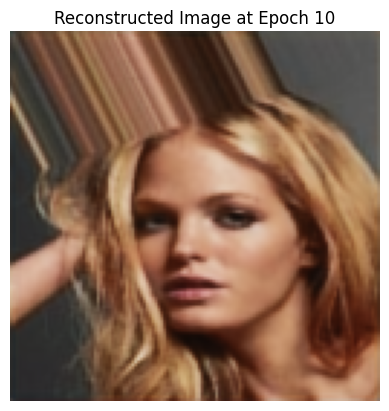

Epoch [11/500], Loss: 6.1718
Epoch [12/500], Loss: 5.8722
Epoch [13/500], Loss: 5.5544
Epoch [14/500], Loss: 5.2696
Epoch [15/500], Loss: 5.0170
Epoch [16/500], Loss: 4.7884
Epoch [17/500], Loss: 4.5989
Epoch [18/500], Loss: 4.4177
Epoch [19/500], Loss: 4.2600
Epoch [20/500], Loss: 4.1267


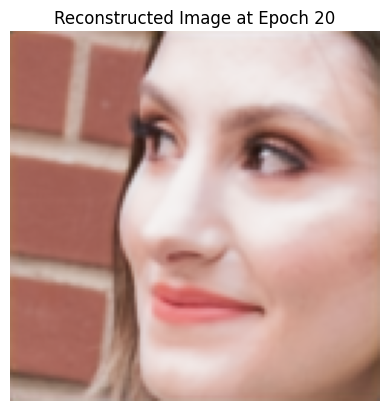

Epoch [21/500], Loss: 4.0078
Epoch [22/500], Loss: 3.8940
Epoch [23/500], Loss: 3.8024
Epoch [24/500], Loss: 3.7162
Epoch [25/500], Loss: 3.6449
Epoch [26/500], Loss: 3.5693
Epoch [27/500], Loss: 3.4969
Epoch [28/500], Loss: 3.4455
Epoch [29/500], Loss: 3.3893
Epoch [30/500], Loss: 3.3283


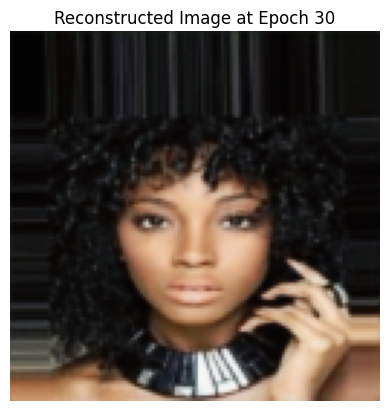

Epoch [31/500], Loss: 3.2898
Epoch [32/500], Loss: 3.2350
Epoch [33/500], Loss: 3.1933
Epoch [34/500], Loss: 3.1634
Epoch [35/500], Loss: 3.1269
Epoch [36/500], Loss: 3.0865
Epoch [37/500], Loss: 3.0478
Epoch [38/500], Loss: 3.0161
Epoch [39/500], Loss: 2.9971
Epoch [40/500], Loss: 2.9674


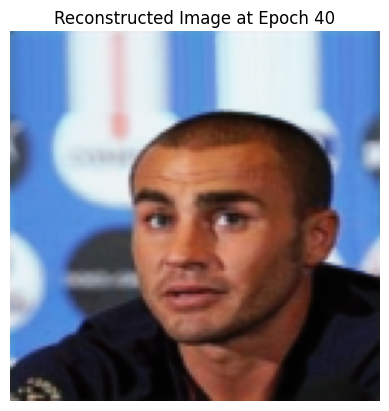

Epoch [41/500], Loss: 2.9291
Epoch [42/500], Loss: 2.9020
Epoch [43/500], Loss: 2.8700
Epoch [44/500], Loss: 2.8491
Epoch [45/500], Loss: 2.8170
Epoch [46/500], Loss: 2.7956
Epoch [47/500], Loss: 2.7682
Epoch [48/500], Loss: 2.7497
Epoch [49/500], Loss: 2.7293
Epoch [50/500], Loss: 2.6993


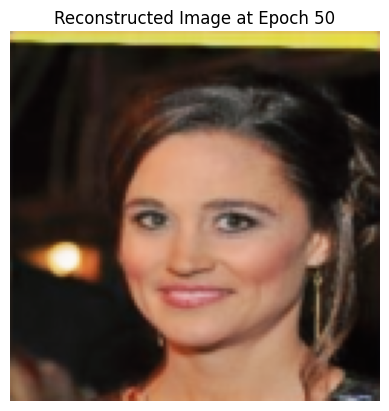

Epoch [51/500], Loss: 2.6825
Epoch [52/500], Loss: 2.6571
Epoch [53/500], Loss: 2.6437
Epoch [54/500], Loss: 2.6206
Epoch [55/500], Loss: 2.6035
Epoch [56/500], Loss: 2.5828
Epoch [57/500], Loss: 2.5622
Epoch [58/500], Loss: 2.5560
Epoch [59/500], Loss: 2.5317
Epoch [60/500], Loss: 2.5090


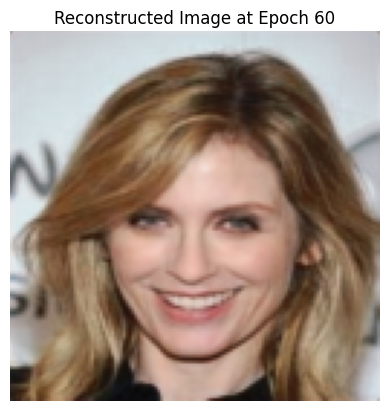

Epoch [61/500], Loss: 2.5005
Epoch [62/500], Loss: 2.4779
Epoch [63/500], Loss: 2.4658
Epoch [64/500], Loss: 2.4480
Epoch [65/500], Loss: 2.4353
Epoch [66/500], Loss: 2.4177
Epoch [67/500], Loss: 2.4013
Epoch [68/500], Loss: 2.3904
Epoch [69/500], Loss: 2.3830
Epoch [70/500], Loss: 2.3605


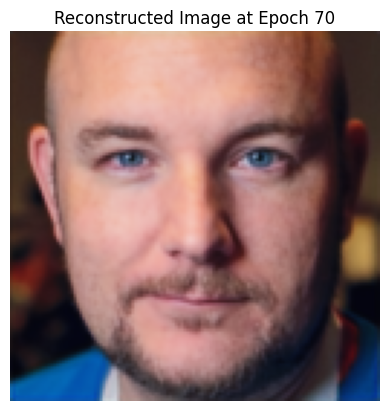

Epoch [71/500], Loss: 2.3453
Epoch [72/500], Loss: 2.3284
Epoch [73/500], Loss: 2.3301
Epoch [74/500], Loss: 2.3065
Epoch [75/500], Loss: 2.2968
Epoch [76/500], Loss: 2.2783
Epoch [77/500], Loss: 2.2669
Epoch [78/500], Loss: 2.2637
Epoch [79/500], Loss: 2.2420
Epoch [80/500], Loss: 2.2334


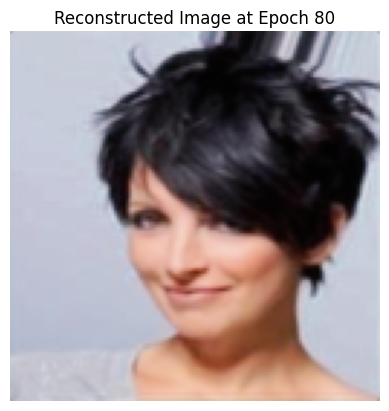

Epoch [81/500], Loss: 2.2219
Epoch [82/500], Loss: 2.2045
Epoch [83/500], Loss: 2.2024
Epoch [84/500], Loss: 2.1828
Epoch [85/500], Loss: 2.1748
Epoch [86/500], Loss: 2.1616
Epoch [87/500], Loss: 2.1582
Epoch [88/500], Loss: 2.1426
Epoch [89/500], Loss: 2.1298
Epoch [90/500], Loss: 2.1248


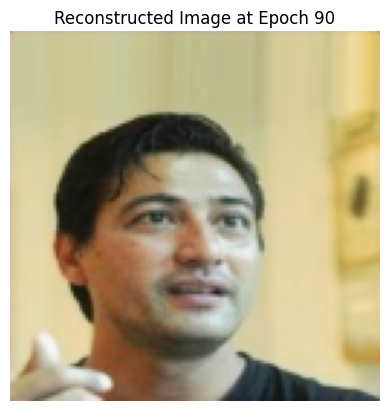

Epoch [91/500], Loss: 2.1121
Epoch [92/500], Loss: 2.1067
Epoch [93/500], Loss: 2.0911
Epoch [94/500], Loss: 2.0886
Epoch [95/500], Loss: 2.0664
Epoch [96/500], Loss: 2.0581
Epoch [97/500], Loss: 2.0487
Epoch [98/500], Loss: 2.0396
Epoch [99/500], Loss: 2.0276
Epoch [100/500], Loss: 2.0204


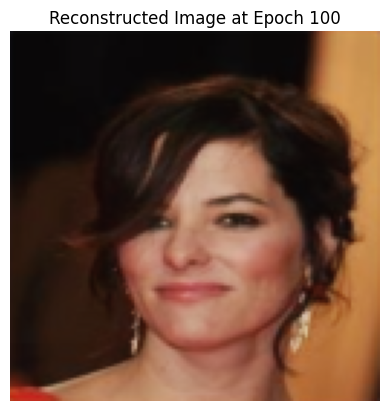

Epoch [101/500], Loss: 2.0098
Epoch [102/500], Loss: 2.0012
Epoch [103/500], Loss: 1.9940
Epoch [104/500], Loss: 1.9824
Epoch [105/500], Loss: 1.9716
Epoch [106/500], Loss: 1.9633
Epoch [107/500], Loss: 1.9517
Epoch [108/500], Loss: 1.9466
Epoch [109/500], Loss: 1.9346
Epoch [110/500], Loss: 1.9244


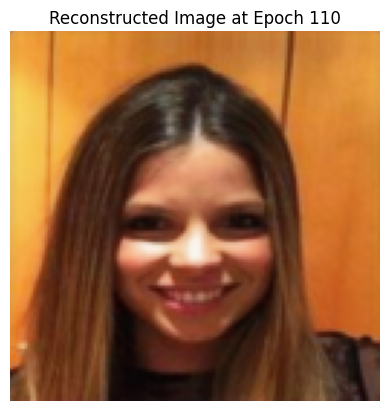

Epoch [111/500], Loss: 1.9185
Epoch [112/500], Loss: 1.9050
Epoch [113/500], Loss: 1.9001


KeyboardInterrupt: 

In [31]:
for epoch in range(1, EPOCHS + 1):
    b_loss = 0
    for image, _ in dataloader:
        image = image.to(device_main)
        reconstructed = autoencoder(image)

        # MSE Loss
        loss_mse = mse_loss(reconstructed, image)

        # Perceptual Loss
        with torch.no_grad():
            features_real = vgg_extractor(image.detach().to(device_vgg))
            features_fake = vgg_extractor(reconstructed.detach().to(device_vgg))

        loss_perceptual = 0
        for fr, ff in zip(features_real, features_fake):
            loss_perceptual += mse_loss(fr, ff)

        # Combined Loss
        loss = alpha * loss_mse + beta * loss_perceptual
        b_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch}/{EPOCHS}], Loss: {b_loss:.4f}")

    if epoch % 10 == 0:
            r_image_np = reconstructed[0].detach().cpu().permute(1, 2, 0).numpy()
            
            plt.imshow(r_image_np)
            plt.title(f"Reconstructed Image at Epoch {epoch}")
            plt.axis("off")
            plt.show()

## Real detector of GAN generated images

In [11]:
transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor(),
    v2.Normalize([0.5]*3, [0.5]*3)
])

In [12]:
from collections import OrderedDict

autoencoder_h = AutoencoderHigh().to(device)
autoencoder_l = AutoencoderLow().to(device)
autoencoder_n = AutoencoderNon().to(device)


state_dict_h = torch.load("/kaggle/input/autoencoders/pytorch/default/1/autoencoder_h.pth", weights_only=True)
state_dict_l = torch.load("/kaggle/input/autoencoders/pytorch/default/1/autoencoder_l.pth", weights_only=True)
state_dict_n = torch.load("/kaggle/input/autoencoders/pytorch/default/1/autoencoder_n.pth", weights_only=True)


def new_state(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  
        new_state_dict[new_key] = v

    return new_state_dict


autoencoder_h.load_state_dict(new_state(state_dict_h))
autoencoder_l.load_state_dict(new_state(state_dict_l))
autoencoder_n.load_state_dict(new_state(state_dict_n))

<All keys matched successfully>

In [13]:
def fft2(image):
    if image.ndim == 3:
        image = image.squeeze(0)  # Remove o canal extra [1, H, W] → [H, W]

    gray_scale = v2.Grayscale()
    image = gray_scale(image)
    
    fft = torch.fft.fft2(image)
    mag = torch.abs(fft)         
    #mag = mag.unsqueeze(0)
    
    return mag

## Custom dataset with autoencoders

In [142]:
image_dir = "/kaggle/input/real-and-fake-images/dataset/train/real_images"


class CustomDataset(Dataset):
    def __init__(self, image_dir, autoencoder_h, autoencoder_l, autoencoder_n, device='cuda', transform=None):
        self.image_dir = image_dir
        self.image_pths = sorted(os.listdir(image_dir))
        self.autoencoder_h = autoencoder_h.to(device).eval()
        self.autoencoder_l = autoencoder_l.to(device).eval()
        self.autoencoder_n = autoencoder_n.to(device).eval()
        self.device = device
        self.transform = transform   
        
    def __len__(self):
        return len(os.listdir(self.image_dir))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_pths[idx])
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).to(self.device)


        real_image = img_tensor

        with torch.no_grad():
            fake_high = self.autoencoder_h(img_tensor.unsqueeze(0)).squeeze(0)
            fake_low  = self.autoencoder_l(img_tensor.unsqueeze(0)).squeeze(0)
            fake_non  = self.autoencoder_n(img_tensor.unsqueeze(0)).squeeze(0)


        real_label = torch.tensor([1, 0], dtype=torch.float32)  # One-hot: [real, fake]
        fake_label = torch.tensor([0, 1], dtype=torch.float32)  # One-hot: [real, fake]

        real_image = fft2(real_image)
        fake_high = fft2(fake_high)
        fake_low = fft2(fake_low)
        fake_non = fft2(fake_non)

       
        real_images = [real_image, real_image.clone(), real_image.clone()]
        real_labels = [1] * 3  
    
       
        fake_images = [fake_high, fake_low, fake_non]
        fake_labels = [0] * 3

        return real_images + fake_images, real_labels+fake_labels

In [143]:
def custom_collate(batch):
    imgs = []
    labs = []
    for images, labels in batch:
        imgs.extend(images)
        labs.extend(labels)
    imgs = torch.stack(imgs)
    labs = torch.tensor(labs, dtype=torch.long)
    return imgs, labs

In [144]:
dataset = CustomDataset(image_dir,
                       autoencoder_h,
                       autoencoder_l,
                       autoencoder_n,
                       device=device,
                       transform=transform)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)

In [14]:
model = resnet50(pretrained=True)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s] 


In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training the classification method

In [147]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_imgs, batch_labels in train_loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        optimizer.zero_grad()

        outputs = model(batch_imgs)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_imgs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.4667
Epoch 2/20, Loss: 0.2511
Epoch 3/20, Loss: 0.1766
Epoch 4/20, Loss: 0.1427
Epoch 5/20, Loss: 0.1194
Epoch 6/20, Loss: 0.0944
Epoch 7/20, Loss: 0.0760
Epoch 8/20, Loss: 0.0651
Epoch 9/20, Loss: 0.0549
Epoch 10/20, Loss: 0.0623
Epoch 11/20, Loss: 0.0417
Epoch 12/20, Loss: 0.0494
Epoch 13/20, Loss: 0.0225
Epoch 14/20, Loss: 0.0315
Epoch 15/20, Loss: 0.0376
Epoch 16/20, Loss: 0.0226
Epoch 17/20, Loss: 0.0181
Epoch 18/20, Loss: 0.0236
Epoch 19/20, Loss: 0.0286
Epoch 20/20, Loss: 0.0146


In [149]:
torch.save(model.state_dict(), "JEONG_model.pth")

## Validation dataset

In [15]:
class ValidationDataset(Dataset):
    def __init__(self, image_dir, device='cuda', transform=None):
        self.device = device
        self.transform = transform
        self.samples = []

        # Coleta os caminhos de imagens e rótulos
        for label, subfolder in enumerate(['fake_images', 'real_images']):  # fake = 0, real = 1
            folder_path = os.path.join(image_dir, subfolder)
            for filename in sorted(os.listdir(folder_path)):
                self.samples.append((os.path.join(folder_path, filename), label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img).to(self.device)

        img = fft2(img)

        return img, label

In [16]:
val_dataset = ValidationDataset('/kaggle/input/real-and-fake-images/dataset/validation', device=device, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

## Validation process

In [17]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for image, label in val_dataloader:
        image, label = image.to(device), label.to(device)
        out = model(image)
        _, predicted = torch.max(out, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

    val_acc = correct/total
    print(f"Validation Score: {val_acc}")

Validation Score: 0.5001250312578145


In [19]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for image, label in val_dataloader:
        image, label = image.to(device), label.to(device).float()
        
        out = model(image)
        _, predicted = torch.max(out, 1)
        
        all_preds.append(predicted.cpu())
        all_labels.append(label.cpu().long())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

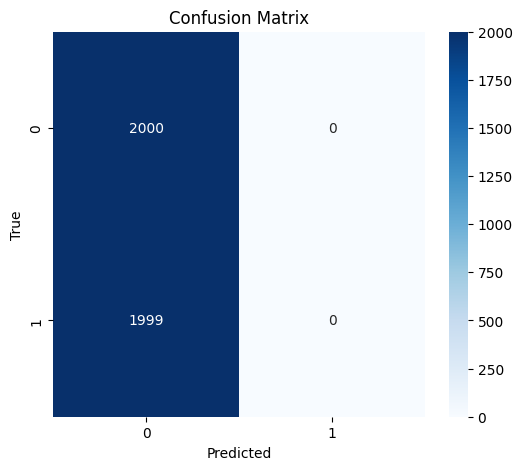

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')  # ou 'macro', 'micro' dependendo do que quiser
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Precision: 0.2501
Recall: 0.5001
F1-score: 0.3335


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
